# Group interactions 


## Introduction
In this tutorial, we will explore the interaction between any number of junctions. 
We will limit ourselves to the interaction between two junctions, but the code can be easily extended to more junctions.

We will use the `GroupInteraction` class to simulate the interaction between the junctions.
It allows us to define the interaction between the junctions based on the distance between the junctions. 

For documentation, see the [API reference](https://lemurpwned.github.io/cmtj//latest/api/reservoir.html#cmtj.reservoir.GroupInteraction).

## Interaction functions
There are three available interaction functions:

1. `nullDipoleInteraction`: This is the default interaction function. It does not take into account the interaction between the junctions.
2. `computeDipoleInteraction`: Simulates dipole interactions, see [1] for more details.
3. `computeDipoleInteractionNoumra`: Similar to 2., also dipole interactions, see [2] for more details.

[1] Kanao et al., *Reservoir Computing on Spin-Torque Oscillator Array* (2019), https://link.aps.org/doi/10.1103/PhysRevApplied.12.024052 
[2] Nomura et al., *Reservoir computing with dipole-coupled nanomagnets* (2019), https://iopscience.iop.org/article/10.7567/1347-4065/ab2406 



## Experiment 

The experiment we will simulate is a two-junction system with a current flowing only through the first junction.
What we want to see is some oscillation in the second junction that is induced by the current flowing through the first junction and the interaction between the junctions.

The coordinate matrix is defined as a list of position vectors, where each position vector represents the position of a junction with respect to (0, 0, 0) origin.

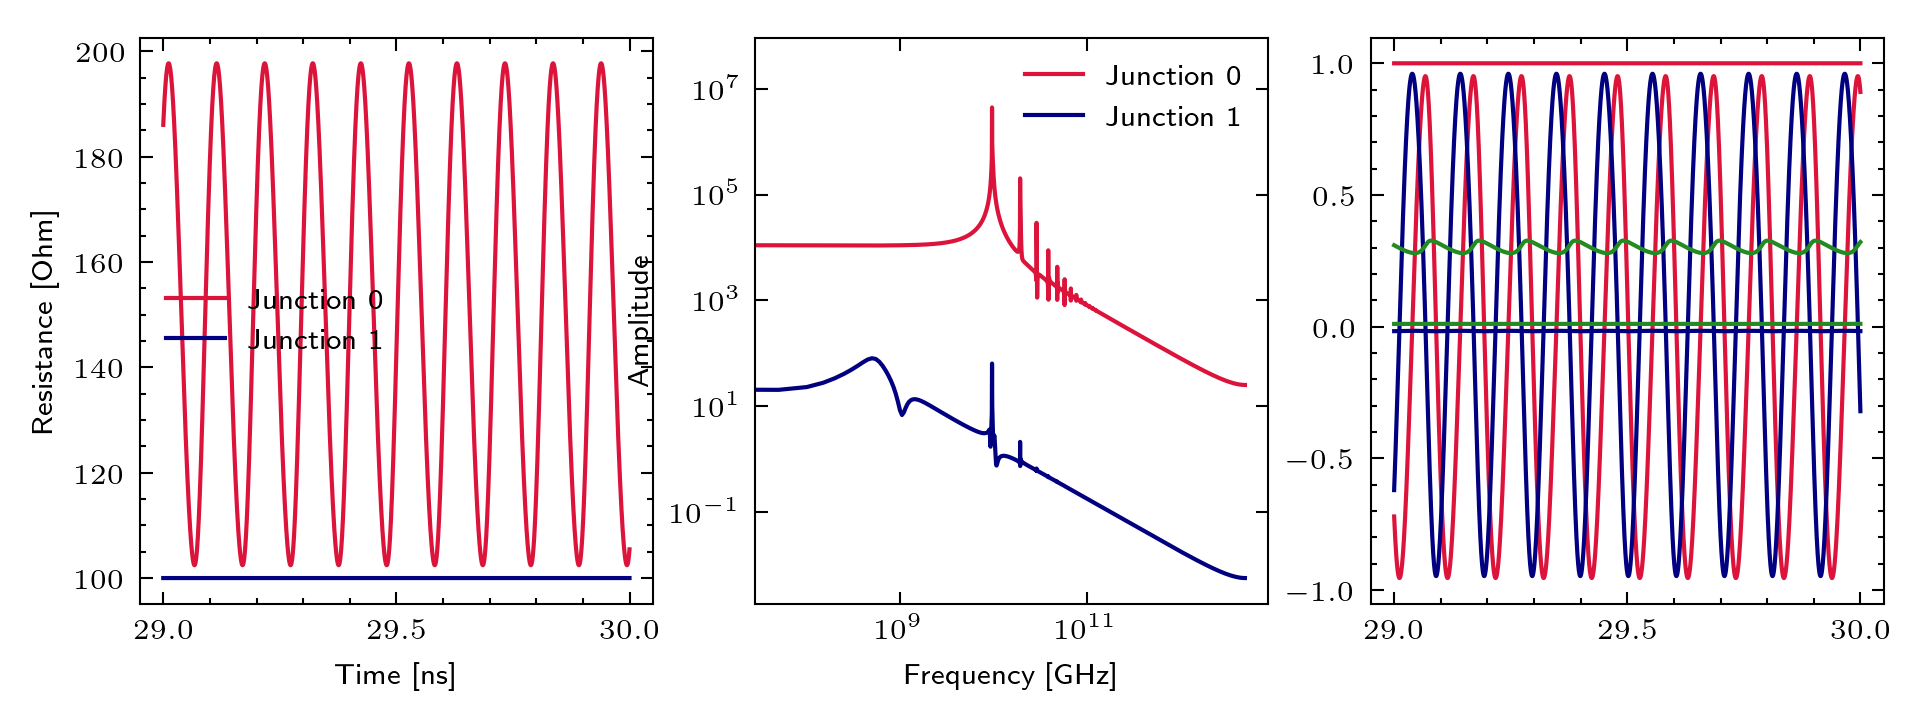

In [8]:
from cmtj.reservoir import (
    GroupInteraction,
    nullDipoleInteraction,
    computeDipoleInteraction,
    computeDipoleInteractionNoumra,
)

from cmtj import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fftfreq, fft


import matplotlib.pyplot as plt

BETA = 0.1


def create_junction(Ms, Ku):
    damping = 1e-2
    surface = np.pi * 50e-9 * 50e-9
    thickness = 3e-9
    spinPolarisation = 0.54
    SLP = spinPolarisation**2
    spinPolarisation = 1
    demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 1)]
    # generate a random start position for the magnetization
    start_m = CVector(
        np.random.uniform(-1, 1), np.random.uniform(-1, 1), np.random.uniform(-1, 1)
    )
    start_m.normalize()
    start_m = CVector(0, 0, 1)
    layer = Layer.createSTTLayer(
        "free",
        start_m,
        CVector(1.0, 0.0, 0.0),
        Ms,
        thickness,
        surface,
        demag,
        damping,
        SLP,
        BETA,
        spinPolarisation,
    )
    layer.setReferenceLayer(CVector(1, 0.0, 0))
    layer.setAnisotropyDriver(constantDriver(Ku))
    return Junction(
        [layer],
        100,
        200,
    )


int_time = 1e-13
Ms = 1.2
Ku = 1e2
m1 = create_junction(Ms, Ku)
m2 = create_junction(Ms, Ku * (1 + 0.5))
jdc = constantDriver(-7e11)
m1.setLayerCurrentDriver("free", jdc)
m1.setLayerExternalFieldDriver("all", AxialDriver(0, 0, 10e3))
m2.setLayerExternalFieldDriver("all", AxialDriver(0, 0, 10e3))
coordinate_matrix = [
    CVector(0, 0, 0),
    CVector(300e-9, 0, 0), # we place the second junction 300 nm away from the first junction in the x direction
]


gi = GroupInteraction(coordinate_matrix, [m1, m2])

gi.clearLogs()

gi.setInteractionFunction(computeDipoleInteractionNoumra)
# gi.setInteractionFunction(nullDipoleInteraction)
gi.runSimulation(30e-9, int_time, int_time)
colors = ["crimson", "navy"]

with plt.style.context(["science", "nature"]):
    w, h = plt.figaspect(1 / 3)
    fig, axs = plt.subplots(1, 3, dpi=300, figsize=(w, h))
    c_is = []
    plot_time = 1
    tm_wait = 10
    for i in range(len(coordinate_matrix)):
        log = gi.getLog(i)
        tm = np.asarray(log["time"]) * 1e9
        R = np.asarray(log["R"])
        des_tm = tm.max() - plot_time
        N = np.argwhere(tm > des_tm).ravel().min()
        axs[0].plot(tm[N:], R[N:], label=f"Junction {i}", color=colors[i])
        # compute fft of R

        idx = np.argwhere(tm > tm_wait).ravel()
        # print(idx)
        R = R[idx]
        fft_R = fft(R)
        freq = fftfreq(len(R), int_time)
        fft_R = np.abs(fft_R)
        fft_R = fft_R[: len(fft_R) // 2]
        freq = freq[: len(freq) // 2]
        axs[1].plot(freq, fft_R, label=f"Junction {i}", color=colors[i])
        lcolors = ["crimson", "navy", "forestgreen"]
        for kl, l in enumerate("xyz"):
            m_l = np.asarray(log[f"free_m{l}"])
            axs[2].plot(tm[N:], m_l[N:], label=f"Junction {i} {l}", color=lcolors[kl])
    axs[0].legend()
    axs[0].set_xlabel("Time [ns]")
    axs[0].set_ylabel("Resistance [Ohm]")
    axs[1].legend()
    axs[1].set_xlabel("Frequency [GHz]")
    axs[1].set_ylabel("Amplitude")
    axs[1].set_xscale("log")
    axs[1].set_yscale("log")